In [ ]:
# https://stackoverflow.com/questions/46397258/how-to-merge-sequential-models-in-keras-2-0
# https://awjuliani.medium.com/visualizing-neural-network-layer-activation-tensorflow-tutorial-d45f8bf7bbc4
# https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759

# #Install ipdb for debugging purpose 
# !pip install -Uqq ipdb
# #For debug 
# import ipdb
# #activate post mortem debugger 
# %pdb on

# mount the collab drive 
from google.colab import drive
drive.mount('/content/gdrive')

# import the zip functionality 
import zipfile
import os

# import the required packages 
import tensorflow as tf
tf.keras.utils.set_random_seed(2022)
from tensorflow.keras import datasets, layers, models
import tensorflow.keras as K
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Settings#

In [ ]:
# ResNet50
# MobileNetV2
# InceptionV3
# EfficientNetB2
trainable = 2 #0-all weights frozen, #1-partial weights frozen, #2-all weights unfrozen
pooling = 'avg'
epochs = 25
lr = 1e-3 #placeholder value. We are using decay learning rate. 
batch_size = 32
# set to true to print layer info, trainable or not
print_layer_info = False
# set to true to print the model structure 
show_model = False
# side function to continue training on a loaded model, please ignore 
cont = False

# define the output path for the models for where the models are saved and later loaded from 
if trainable == 0:
    #path for model
    model_path = '/content/gdrive/My Drive/Colab Notebooks/604_vision/assign_2/model_2/model_a.h5'
    #path for weights 
    model_weights = '/content/gdrive/My Drive/Colab Notebooks/604_vision/assign_2/model_2/model_weights_a.h5' 
elif trainable == 1: 
    #path for model
    model_path = '/content/gdrive/My Drive/Colab Notebooks/604_vision/assign_2/model_2/model_b.h5'
    #path for weights 
    model_weights = '/content/gdrive/My Drive/Colab Notebooks/604_vision/assign_2/model_2/model_weights_b.h5' 
else: 
    #path for model
    model_path = '/content/gdrive/My Drive/Colab Notebooks/604_vision/assign_2/model_2/model_c.h5'
    #path for weights 
    model_weights = '/content/gdrive/My Drive/Colab Notebooks/604_vision/assign_2/model_2/model_weights_c.h5' 

# load the zip file 
zip_ref = zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/604_vision/assign_1/open_images.zip', 'r') 
#Extracts the files into the /tmp folder
zip_ref.extractall('/content/tmp') 
# close the zip
zip_ref.close()

# specify directory to load the unzipped data from
train_directory = '/content/tmp/train'
eval_directory = '/content/tmp/eval'

In [ ]:
# load the train dataset with shuffle 
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_directory,
                                                                    label_mode = 'categorical',
                                                                    seed=123,
                                                                    image_size = (224,224),
                                                                    batch_size = batch_size,
                                                                    )

# load the eval dataset without shuffle 
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(eval_directory,
                                                                   label_mode = 'categorical',
                                                                   shuffle=False,
                                                                   image_size = (224,224),
                                                                   batch_size = batch_size,
                                                                   )

# print the information 
print(train_dataset.class_names)
print(train_dataset)
# save the class names 
class_names = train_dataset.class_names

Found 3750 files belonging to 5 classes.
Found 1250 files belonging to 5 classes.
['apple_pie', 'cheesecake', 'chocolate_cake', 'french_toast', 'garlic_bread']
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


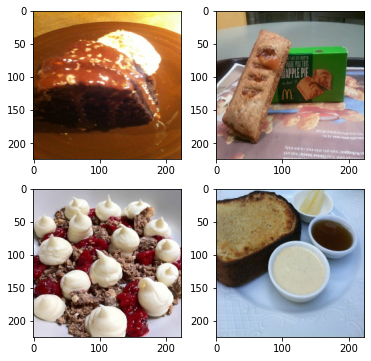

In [ ]:
# https://towardsdatascience.com/practical-coding-in-tensorflow-2-0-fafd2d3863f6
# using the batch to get consistent image samples for viewing
plt.figure(figsize=(6,6))
for images, labels in train_dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i]/255)

#a_model setup#

In [ ]:
# a_model
input_a=K.Input(shape=(224,224,3))
a_model = K.applications.InceptionV3(include_top=False,weights="imagenet",input_tensor=input_a,pooling=pooling) #max,avg,none

# if all weights are to be frozen
if trainable == 0: 
    # set all layers to false 
    for layer in a_model.layers:
        layer.trainable = False

# if all weights are partially frozen 
elif trainable == 1: 
    # set all layers to false 
    for layer in a_model.layers:
        layer.trainable = False
    # set specific layers as true 
    for layer in a_model.layers[-33:]:
        layer.trainable = True
        
# if all weights are unfrozen 
else: 
    # set all layers to false 
    for layer in a_model.layers:
        layer.trainable = False
    # set all as true 
    for layer in a_model.layers:
        layer.trainable = True

if print_layer_info == True: 
    for i, layer in enumerate(a_model.layers):
        print(i, layer.name, "-", layer.trainable)

In [ ]:
# a_model
if show_model == True:
    plot_model(a_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
######################################
###############WEIGHTS################
######################################

# double check the weights 
for layer in a_model.layers[1:2]:
    print("Name of layer:", layer.name, layer)
    # print(layer.get_weights())
    test = layer.get_weights()

dim_1 = len(test[0])
print('filter width dimension =', dim_1)

dim_2 = len(test[0][0])
print('filter height dimension =', dim_2)

dim_3 = len(test[0][0][0])
print('filter depth dimension =', dim_3)

dim_4 = len(test[0][0][0][0])
print('number of filters =', dim_4)

total_elements = dim_1 * dim_2 * dim_3 * dim_4
print('total_elements=',total_elements)

total_weights_before = test[0].sum()
print("total weights=", total_weights_before)

avg_weights_before = total_weights_before/total_elements
print("avg weights=", "{:.6f}".format(avg_weights_before))

Name of layer: conv2d <keras.layers.convolutional.conv2d.Conv2D object at 0x7f155a508ed0>
filter width dimension = 3
filter height dimension = 3
filter depth dimension = 3
number of filters = 32
total_elements= 864
total weights= -0.67274463
avg weights= -0.000779


#b_model#

In [ ]:
# b_model
input_b=K.Input(shape=(224,224,3))
b_model = K.applications.EfficientNetB2(include_top=False,weights="imagenet",input_tensor=input_b,pooling=pooling) #max,avg,none

if trainable == 0: 
    # set all as false
    for layer in b_model.layers:
        layer.trainable = False
elif trainable == 1:
    # set all as false 
    for layer in b_model.layers:
        layer.trainable = False
    # set specific layer as true 
    for layer in b_model.layers[-32:]:
        layer.trainable = True
else: 
    # set all as false 
    for layer in b_model.layers:
        layer.trainable = False
    # set specific layer as true 
    for layer in b_model.layers:
        layer.trainable = True

if print_layer_info == True: 
    for i, layer in enumerate(b_model.layers):
        print(i, layer.name, "-", layer.trainable)

In [ ]:
# b_model
if show_model == True:
    plot_model(b_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#start building model#

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['sequential[0][0]']             
                                                                                              

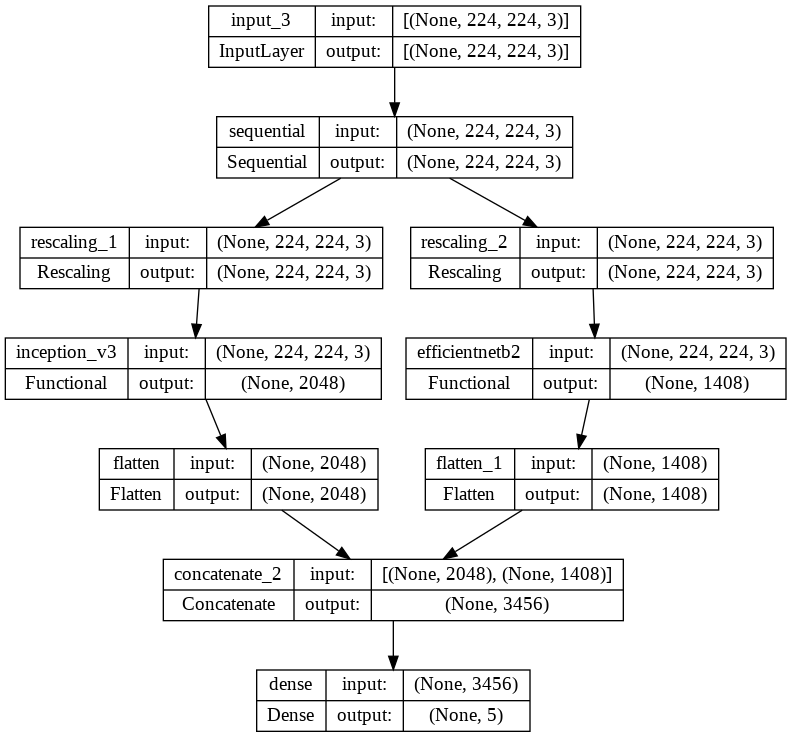

In [ ]:
# create a data augumentation layer to augument the training data
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(224,224,3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)

# set the input 
input_1 = layers.Input(shape=(224,224,3))

# model a 
x = (data_augmentation)(input_1)
x = layers.Rescaling(1.0/255, input_shape=(None,224, 224, 3))(x)
x = (a_model)(x)

# model b
y = (data_augmentation)(input_1)
y = layers.Rescaling(1.0/255, input_shape=(None,224, 224, 3))(y)
y = (b_model)(y)

# logic for pooling method
# if max pooling or avg pooling is selected, there is no need for flatten
if pooling != None:
    x = layers.Flatten()(x)
    y = layers.Flatten()(y)

# https://stackoverflow.com/questions/46397258/how-to-merge-sequential-models-in-keras-2-0
# combine the output of both models 
z = layers.concatenate([x, y], axis=-1)

## Layers below are not used as it is not allowed 
# z = layers.Dropout(0.2)(z)
# z = layers.Dense(512, activation='relu')(z) #512
# z = layers.Dropout(0.2)(z)
# z = layers.BatchNormalization()(z)
# z = layers.Dense(256, activation='relu')(z)
# z = layers.Dropout(0.2)(z)
# z = layers.BatchNormalization()(z)

output_1 = layers.Dense(5, activation='softmax')(z)
model = models.Model(inputs=input_1,outputs=output_1)
print(model.summary())
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#defining callbacks#

In [ ]:
# https://dzlab.github.io/dltips/en/keras/learning-rate-scheduler/
# Define configuration parameters

# Define the scheduling function for ramping 
def ramp_schedule(epoch):
  def lr(epoch, start_lr, rampup_epochs, exp_decay):
    if epoch < rampup_epochs:
      return start_lr
    else:
      return start_lr * math.exp(-exp_decay * epoch)
  return lr(epoch, start_lr, rampup_epochs, exp_decay)

# Define the scheduling function for time based decay
def schedule(epoch):
  previous_lr = 1
  def lr(epoch, start_lr, decay):
    nonlocal previous_lr
    previous_lr *= (start_lr / (1. + decay * epoch))
    return previous_lr
  return lr(epoch, start_lr, decay)

# logic to delect the callback 
# when layers are all frozen, use the ramping callback function 
if trainable == 0: 
    start_lr = 0.0005
    rampup_epochs = 3
    exp_decay = 0.1
    lr_callback = tf.keras.callbacks.LearningRateScheduler(ramp_schedule, verbose=True)

# when layers are not frozen, use the time based decay function 
else:  
    start_lr = 0.00002
    decay = 0.03
    lr_callback = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=True)

# Callback to save model at checkpoints, overwrite with latest best model 
# save inside folder 
checkpoint_filepath = model_weights

best_model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [best_model_callback, lr_callback]

# https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
# meaning for accuracy and loss 
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


# simple logic to allow continued training by loading a previous model, not used anymore. 
if cont == True: 
    model = tf.keras.models.load_model(model_path)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    model.load_weights(model_weights)
# Used for the assignment 
else: 
    # save the model inside own folder
    model.save(model_path)

#training the model#

In [ ]:
print("type:", trainable)
# train the model 
history = model.fit(train_dataset, batch_size=batch_size, validation_data=test_dataset, epochs=epochs, verbose=1, callbacks=callbacks)

type: 2

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/25
118/118 [==============================] - 135s 905ms/step - loss: 1.2015 - accuracy: 0.5379 - val_loss: 1.0356 - val_accuracy: 0.5752 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9417475728155343e-05.
Epoch 2/25
118/118 [==============================] - 99s 839ms/step - loss: 0.6977 - accuracy: 0.7517 - val_loss: 0.6738 - val_accuracy: 0.7600 - lr: 1.9417e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.8867924528301888e-05.
Epoch 3/25
118/118 [==============================] - 99s 837ms/step - loss: 0.5441 - accuracy: 0.8056 - val_loss: 0.5757 - val_accuracy: 0.7928 - lr: 1.8868e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.8348623853211008e-05.
Epoch 4/25
118/118 [==============================] - 100s 840ms/step - loss: 0.4545 - accuracy: 0.8443 - val_loss: 0.5364 - val_accuracy: 0.8080 - lr: 1.8349e-05

Epoch 5: LearningRateScheduler set

In [ ]:
######################################
###############WEIGHTS################
######################################

# double check the weights 
for layer in a_model.layers[1:2]:
    print("Name of layer:", layer.name, layer)
    # print(layer.get_weights())
    test = layer.get_weights()

dim_1 = len(test[0])
print('filter width dimension =', dim_1)

dim_2 = len(test[0][0])
print('filter height dimension =', dim_2)

dim_3 = len(test[0][0][0])
print('filter depth dimension =', dim_3)

dim_4 = len(test[0][0][0][0])
print('number of filters =', dim_4)

total_elements = dim_1 * dim_2 * dim_3 * dim_4
print('total_elements=',total_elements)

total_weights_after = test[0].sum()
print("total weights=", total_weights_after)

avg_weights_after = total_weights_after/total_elements
print("avg weights=", "{:.6f}".format(avg_weights_after))
print("avg weights before =", "{:.6f}".format(avg_weights_before),'\n')

# show the outcome
print('Before = After ?')
print(avg_weights_after == avg_weights_before)

Name of layer: conv2d <keras.layers.convolutional.conv2d.Conv2D object at 0x7f155a508ed0>
filter width dimension = 3
filter height dimension = 3
filter depth dimension = 3
number of filters = 32
total_elements= 864
total weights= -0.5528536
avg weights= -0.000640
avg weights before = -0.000779 

Before = After ?
False


In [ ]:
# save the model 
model.save(model_path)

# reload the model for inference purpose 
# we choose not to compile here because we need to use our own loss function 
model = tf.keras.models.load_model(model_path,compile=False)
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.load_weights(model_weights)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test data
40/40 [==============================] - 12s 165ms/step - loss: 0.4838 - accuracy: 0.8592
test loss, test acc: [0.48384764790534973, 0.8592000007629395]


#plot training history#

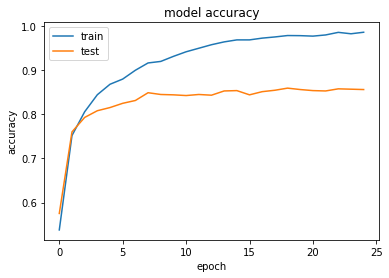

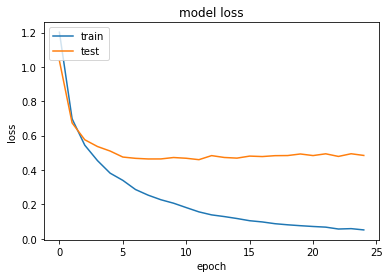

In [ ]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#plot confusion matrix#

40/40 [==============================] - 10s 163ms/step


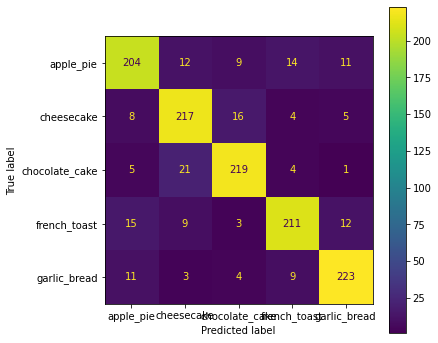

In [ ]:
# https://www.pythonfixing.com/2021/11/fixed-how-to-plot-confusion-matrix-for.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

# create and plot confusion matrix 
y_pred = model.predict(test_dataset)
predicted_categories = tf.argmax(y_pred, axis=1)
x = tf.concat([y for x, y in test_dataset], axis=0)
true_categories = tf.argmax(x, axis=1)
cm = confusion_matrix(y_true=true_categories, y_pred= predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['apple_pie', 'cheesecake', 'chocolate_cake', 'french_toast', 'garlic_bread'])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax)

#classification report#

In [ ]:
y_pred_index = np.argmax(y_pred,axis=1)
y_actual = np.concatenate([y for x, y in test_dataset], axis=0)
y_actual_index = np.argmax(y_actual,axis=1)
class_labels = test_dataset.class_names
# create classification report 
print(classification_report(y_true=y_actual_index, y_pred=y_pred_index, target_names=class_labels))

                precision    recall  f1-score   support

     apple_pie       0.84      0.82      0.83       250
    cheesecake       0.83      0.87      0.85       250
chocolate_cake       0.87      0.88      0.87       250
  french_toast       0.87      0.84      0.86       250
  garlic_bread       0.88      0.89      0.89       250

      accuracy                           0.86      1250
     macro avg       0.86      0.86      0.86      1250
  weighted avg       0.86      0.86      0.86      1250



#micro-macro-weighted score#

In [ ]:
# # calculate the various score 
types = ['micro','macro','weighted']
for kind in types:
    print(kind,'precision score:',precision_score(y_true=y_actual_index, y_pred=y_pred_index,average=kind))
    print(kind,'recall score:',recall_score(y_true=y_actual_index, y_pred=y_pred_index,average=kind))
    print(kind,'f1 score:',f1_score(y_true=y_actual_index, y_pred=y_pred_index,average=kind))

micro precision score: 0.8592
micro recall score: 0.8592
micro f1 score: 0.8592000000000001
macro precision score: 0.8594163738349889
macro recall score: 0.8592000000000001
macro f1 score: 0.8591327492555509
weighted precision score: 0.8594163738349889
weighted recall score: 0.8592
weighted f1 score: 0.8591327492555508


#per-class accuracy#

In [ ]:
# calculate the class accuracy 
for index in range(5): 
    correctly_predicted = cm[index][index]
    sum = cm[index].sum()
    class_accuracy = correctly_predicted/sum
    print(class_labels[index],':',class_accuracy)

apple_pie : 0.816
cheesecake : 0.868
chocolate_cake : 0.876
french_toast : 0.844
garlic_bread : 0.892
